My friend [Sam](https://github.com/swyatt7) is part of a team building a [Gravitational Wave Treasure Map](http://treasuremap.space/). Due to the way gravitational wave telescopes (e.g., [LIGO](https://en.wikipedia.org/wiki/LIGO)) work, gravitational wave events can only be roughly localized on the sky. For example, gravitational wave event [S190923y](https://gracedb.ligo.org/superevents/S190923y/view/) could have come from anywhere in the dark red regions here:

<div style="width: 50%; margin: 0 auto"><img alt="A poorly localized GW event" src="https://gracedb.ligo.org/apiweb/superevents/S190923y/files/bayestar.png,0">
</div>

As soon as a detection is made, alerts are sent out to the astronomical community. Teams of astronomers around the world then search the indicated region for new points of light, in hopes of finding an optical (electromagnetic) counterpart. They report back which regions of the sky they imaged, and the treasure map shows where to focus further searches.

In the course of developing this map, he ran in to a classic coordinate singularity problem, and I helped him work out the math behind it.

# The _singularity_

Astronomers locate objects in angular coordinates, right ascension (RA) and declination (Dec)—analogous to longitude and latitude respectively. The problem is that, when your declination goes to $\pm 90^\circ$, your right ascension is undefined. (Just like when you're standing at the North Pole, you don't have a particular longitude.)

So, say you have a telescope that images a $10^\circ \times 10^\circ$ field of view. That's 10 degrees from the telescope pointing location, not 10 degrees RA by 10 degrees Dec. It's easy to see why: define a square centered at $(0^\circ, 0^\circ)$:

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.print_figure_kwargs = {'facecolor': (1.0, 1.0, 1.0, 0.0)}
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'font.family': 'serif',
    'axes.grid': True,
    'figure.figsize': (7, 7)
})

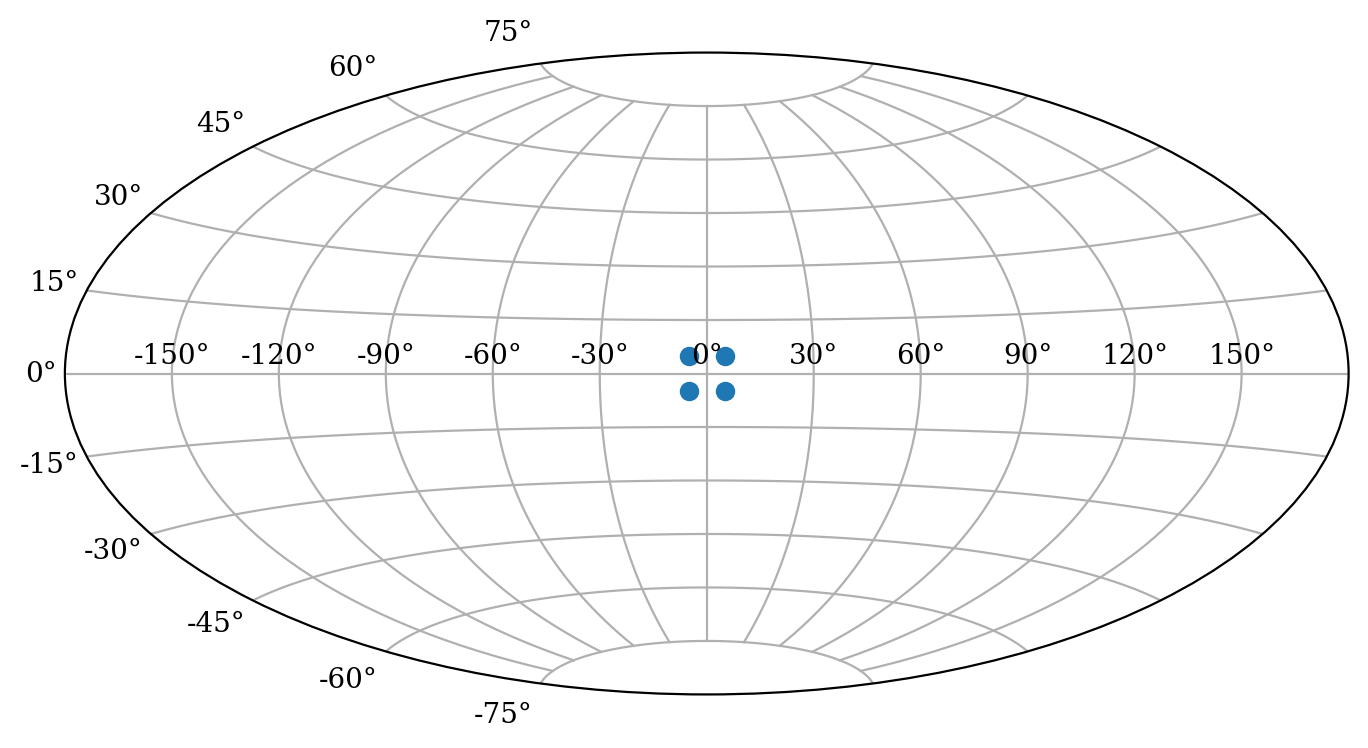

In [2]:
footprint_zero_center = [
    [-5, 5],
    [5, 5],
    [5, -5],
    [-5, -5],
]
footprint_zero_center_ra = np.asarray([
    pt[0] for pt in footprint_zero_center
])
footprint_zero_center_dec = np.asarray([
    pt[1] for pt in footprint_zero_center
])
ax = plt.subplot(111, projection='aitoff')
ax.scatter(
    np.deg2rad(footprint_zero_center_ra),
    np.deg2rad(footprint_zero_center_dec)
)
plt.tight_layout()

And try to move it up to the pole:

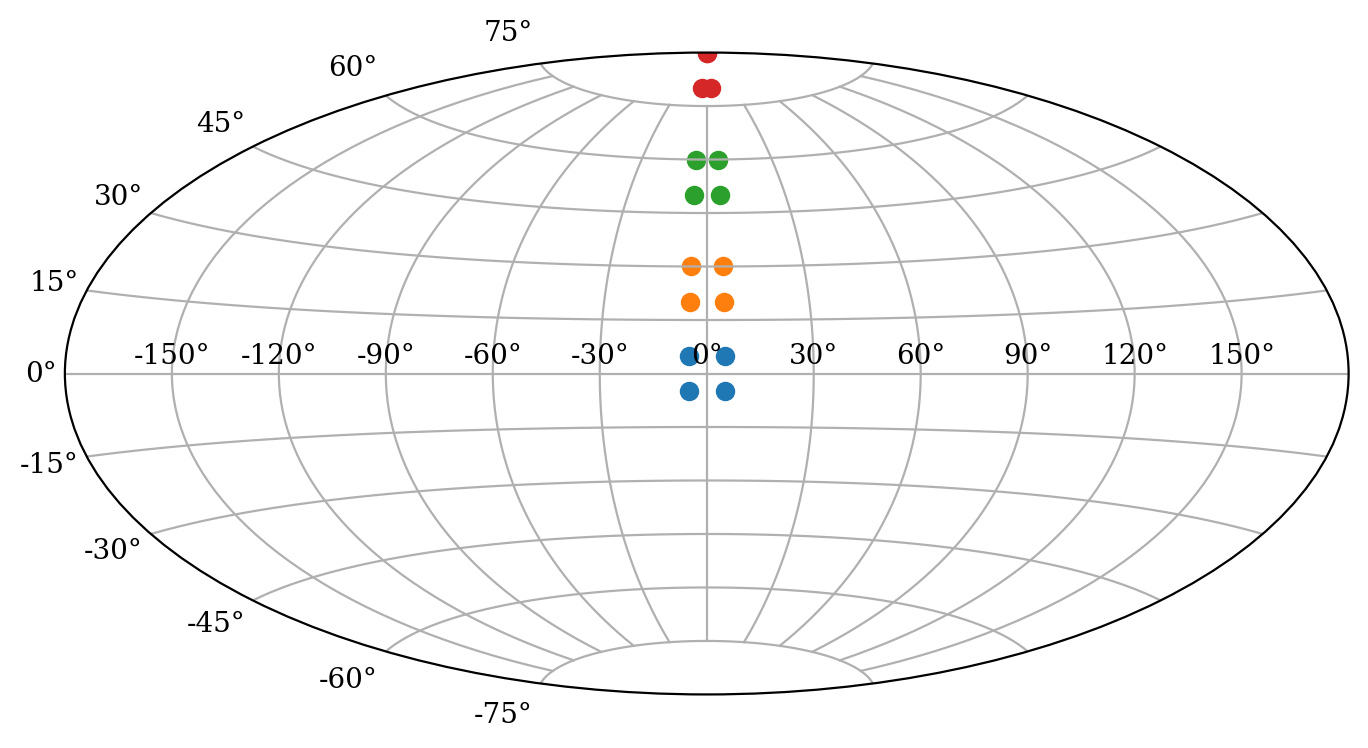

In [3]:
ax = plt.subplot(111, projection='aitoff')
ax.scatter(
    np.deg2rad(footprint_zero_center_ra),
    np.deg2rad(footprint_zero_center_dec)
)
ax.scatter(
    np.deg2rad(footprint_zero_center_ra),
    np.deg2rad(footprint_zero_center_dec + 25)
)
ax.scatter(
    np.deg2rad(footprint_zero_center_ra),
    np.deg2rad(footprint_zero_center_dec + 55)
)
ax.scatter(
    np.deg2rad(footprint_zero_center_ra),
    np.deg2rad(footprint_zero_center_dec + 85)
)
plt.tight_layout()

If you have centered on $(0^\circ, 85^\circ)$, you'll have a corner at $(-5^\circ, 90^\circ)$ and $(5^\circ, 90^\circ)$. But, of course, RA is undefined when Dec is $90^\circ$! In other words, the two top corners end up occupying the same point, and your footprint is clearly not $10^\circ$ by $10^\circ$ any more.

My friend encountered this when he tried to place detector footprint outlines at the pole for a visualization. There were division by zero errors, wild distortions... basically, it didn't work.

It turns out there's **no** simple formula to move your polygon around in angular coordinates while preserving surface area (solid angle).

# Transforming into a higher dimensional space

Actually, that's not entirely true. There's no simple **2-D** formula. If you convert into 3D Cartesian coordinates, you can apply standard rotation matrices to move your footprint where-ever you like.

If we have $\text{RA} \in [0^\circ,\ 360^\circ]$ and $\text{Dec} \in [-90^\circ,\ 90^\circ]$, we can convert to Cartesian coordinates by first defining

$$
\begin{align*}
    \phi &= (90^\circ - \text{Dec}) \times \frac{\pi}{180^\circ}\\
    \theta &= \text{RA} \times \frac{\pi}{180^\circ}\\
\end{align*}
$$

Then using the [usual](http://mathworld.wolfram.com/SphericalCoordinates.html) conventions, our coordinates are

$$
\begin{align*}
    x &= r \cos \theta \sin \phi \\
    y &= r \sin \theta \sin \phi \\
    z &= r \cos \phi
\end{align*}
$$

but we only care about the surface of the unit sphere, so we always have $r = 1$. Let's define the functions to convert back and forth:

In [4]:
def ra_dec_to_uvec(ra, dec):
    phi = np.deg2rad(90 - dec)
    theta = np.deg2rad(ra)
    x = np.cos(theta) * np.sin(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(phi)
    return x, y, z

With the conventions we've chosen, $(\text{RA},\ \text{Dec}) = (0^\circ,\ 0^\circ)$ should be along the X axis. Check and see:

In [5]:
ra_dec_to_uvec(0, 0)

(1.0, 0.0, 6.123233995736766e-17)

Slight imprecisions in the conversion of the Dec coordinate led to a negligible nonzero $z$ component, but otherwise everything seems correct.

Verify that $\text{Dec}\,=\,90^\circ$ is along the Z axis:

In [6]:
ra_dec_to_uvec(0, 90)

(0.0, 0.0, 1.0)

$\text{RA}\,=\,90^\circ$ is along Y.

In [7]:
ra_dec_to_uvec(90, 0)

(6.123233995736766e-17, 1.0, 6.123233995736766e-17)

Let's go the other way:

In [8]:
def uvec_to_ra_dec(x, y, z):
    r = np.sqrt(x**2 + y ** 2 + z ** 2)
    theta = np.arctan2(y, x)
    phi = np.arccos(z)
    dec = 90 - np.rad2deg(phi)
    if theta < 0:
        ra = 360 + np.rad2deg(theta)
    else:
        ra = np.rad2deg(theta)
    return ra, dec

Two things to note: we're using the [`arctan2`](https://en.wikipedia.org/wiki/Atan2) function, which produces $\theta$ with the correct sign. We then handle negative angles specially to ensure $\text{RA} \in [0^\circ, 360^\circ]$. Check a few cases:

In [9]:
uvec_to_ra_dec(1.0, 0.0, 0.0)

(0.0, 0.0)

In [10]:
uvec_to_ra_dec(*ra_dec_to_uvec(90, 0))

(90.0, 0.0)

In [11]:
uvec_to_ra_dec(*ra_dec_to_uvec(0, 90))

(0.0, 90.0)

Convert the whole footprint:

In [12]:
footprint_zero_center_uvec = ra_dec_to_uvec(
    footprint_zero_center_ra,
    footprint_zero_center_dec
)
(
    footprint_zero_center_x,
    footprint_zero_center_y,
    footprint_zero_center_z
) = footprint_zero_center_uvec

And plot it in 3D:

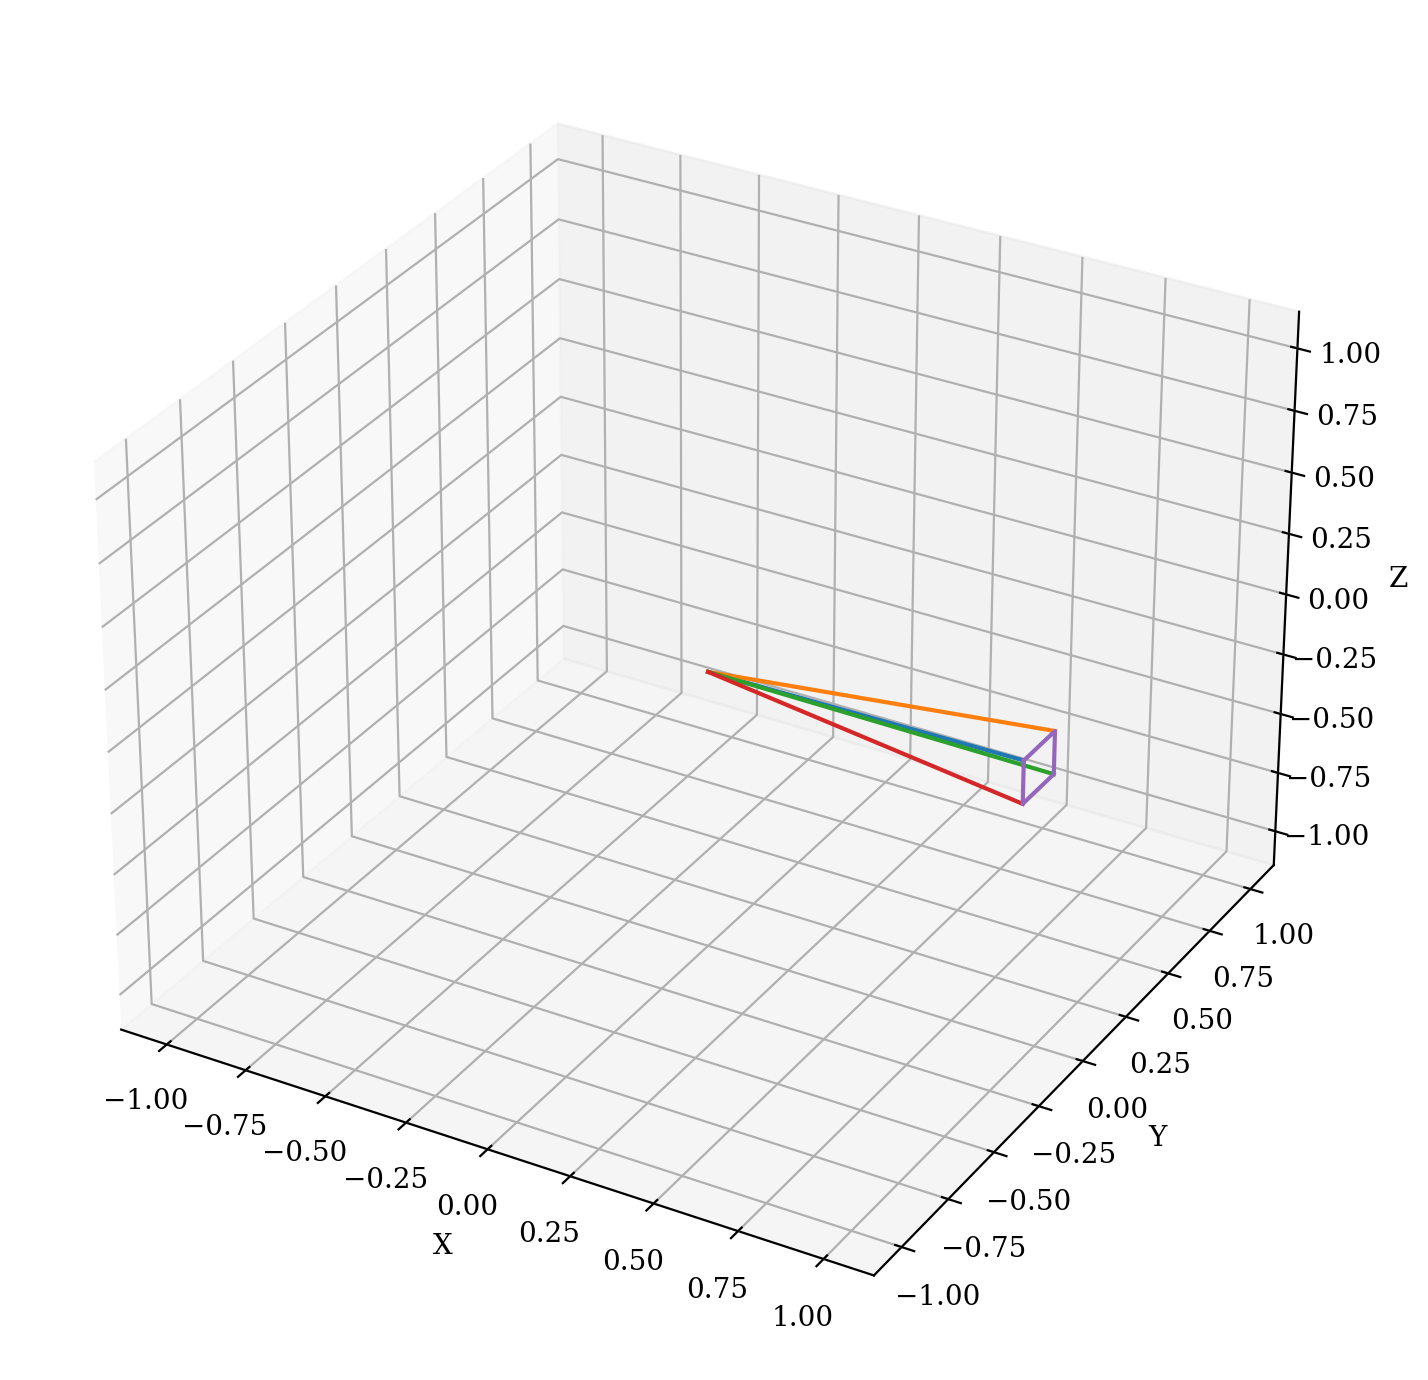

In [13]:
from mpl_toolkits.mplot3d import Axes3D
def make_3d_axes(rows=1, cols=1, loc=1):
    ax = plt.gcf().add_subplot(rows, cols, loc, projection='3d')
    ax.set_facecolor([0, 0, 0, 0])
    minval, maxval = -1.1, 1.1
    ax.set_xlim(minval, maxval)
    ax.set_ylim(minval, maxval)
    ax.set_zlim(minval, maxval)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return ax

def vec_from_origin(x, y, z):
    return [0, x], [0, y], [0, z]

fig = plt.figure()
ax = make_3d_axes()
xs, ys, zs = [], [], []
for idx in range(footprint_zero_center_x.shape[0]):
    ax.plot(*vec_from_origin(
        footprint_zero_center_x[idx],
        footprint_zero_center_y[idx],
        footprint_zero_center_z[idx]
    ))
    xs.append(footprint_zero_center_x[idx])
    ys.append(footprint_zero_center_y[idx])
    zs.append(footprint_zero_center_z[idx])

# close the square
xs.append(xs[0])
ys.append(ys[0])
zs.append(zs[0])
ax.plot(xs, ys, zs)
plt.tight_layout()

To move this footprint around on the sphere, we rotate the vectors from the origin to each corner using a [rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix#Basic_rotations). Since we already have a $\theta$ running around, let's call the angle of rotation $\gamma$. Then, the basic rotation matrices for rotation about the $x$, $y$, and $z$ axes are given by:

\begin{align*}
R_x(\gamma) &= \begin{bmatrix}
1 & 0 & 0 \\
0 & \cos \gamma &  -\sin \gamma \\[3pt]
0 & \sin \gamma  &  \cos \gamma \\[3pt]
\end{bmatrix} \\
R_y(\gamma) &= \begin{bmatrix}
\cos \gamma & 0 & \sin \gamma \\[3pt]
0 & 1 & 0 \\[3pt]
-\sin \gamma & 0 & \cos \gamma \\
\end{bmatrix} \\
R_z(\gamma) &= \begin{bmatrix}
\cos \gamma &  -\sin \gamma & 0 \\[3pt]
\sin \gamma &   \cos \gamma & 0\\[3pt]
0 & 0 & 1\\
\end{bmatrix}
\end{align*}

Or, in code:

In [14]:
def x_rot(gamma_deg):
    gamma = np.deg2rad(gamma_deg)
    return np.matrix([
        [1, 0, 0],
        [0, np.cos(gamma), -np.sin(gamma)],
        [0, np.sin(gamma), np.cos(gamma)]
    ])

def y_rot(gamma_deg):
    gamma = np.deg2rad(gamma_deg)
    return np.matrix([
        [np.cos(gamma), 0, np.sin(gamma)],
        [0, 1, 0],
        [-np.sin(gamma), 0, np.cos(gamma)]
    ])

def z_rot(gamma_deg):
    gamma = np.deg2rad(gamma_deg)
    return np.matrix([
        [np.cos(gamma), -np.sin(gamma), 0],
        [np.sin(gamma), np.cos(gamma), 0],
        [0, 0, 1]
    ])

Let's examine the effects of these transformations on the $\hat{x}$, $\hat{y}$, and $\hat{z}$ vectors:

In [15]:
x_hat = np.array([1, 0, 0])
y_hat = np.array([0, 1, 0])
z_hat = np.array([0, 0, 1])

Here's our starting point

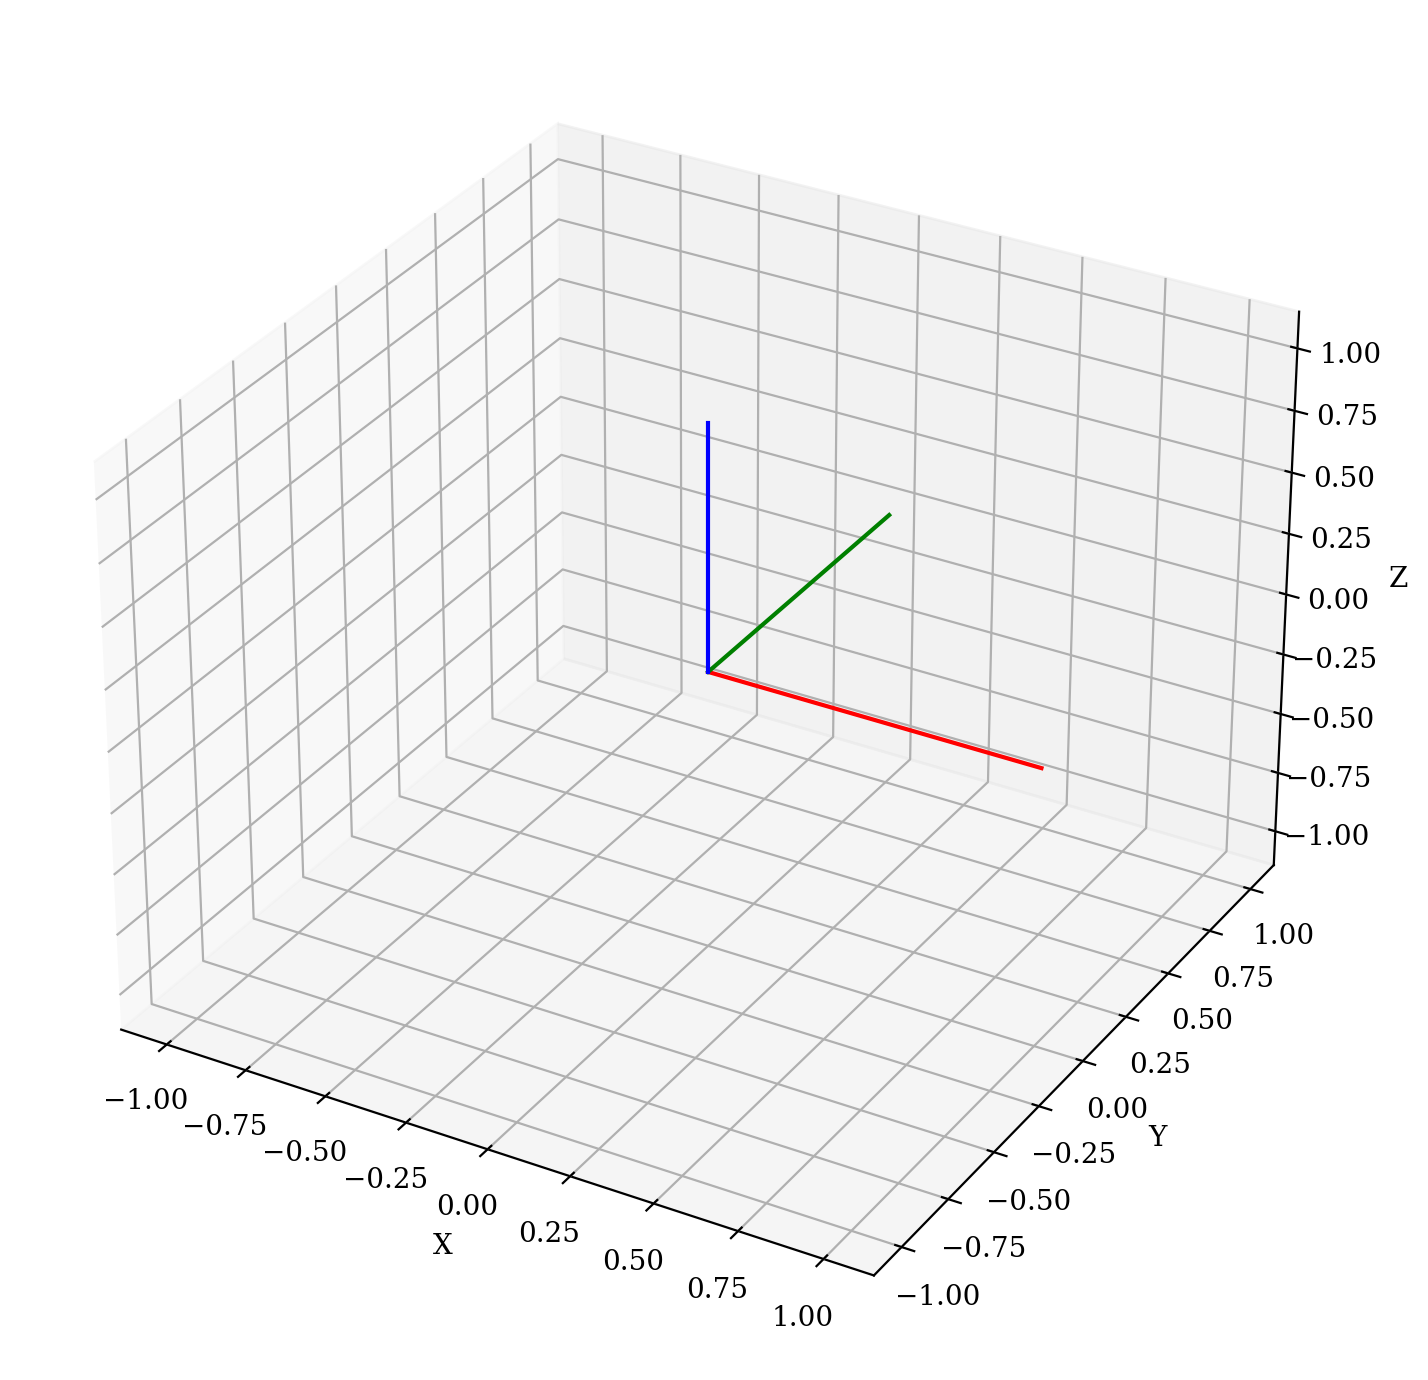

In [16]:
ax = make_3d_axes()
ax.plot(*vec_from_origin(*x_hat), color='red')
ax.plot(*vec_from_origin(*y_hat), color='green')
ax.plot(*vec_from_origin(*z_hat), color='blue')
plt.tight_layout()

We want to rotate about the X axis by 45 degrees. We do this by multiplying on the right by our `x_rot` matrix:

In [17]:
new_x_hat = x_hat @ x_rot(45)
new_y_hat = y_hat @ x_rot(45)
new_z_hat = z_hat @ x_rot(45)

And plotting the result. (Note that the result of the `@` (matrix multiplication) operator with an array on the left and a matrix on the right is a matrix, so we used `new_x_hat.flat` to get the x, y, z components out.)

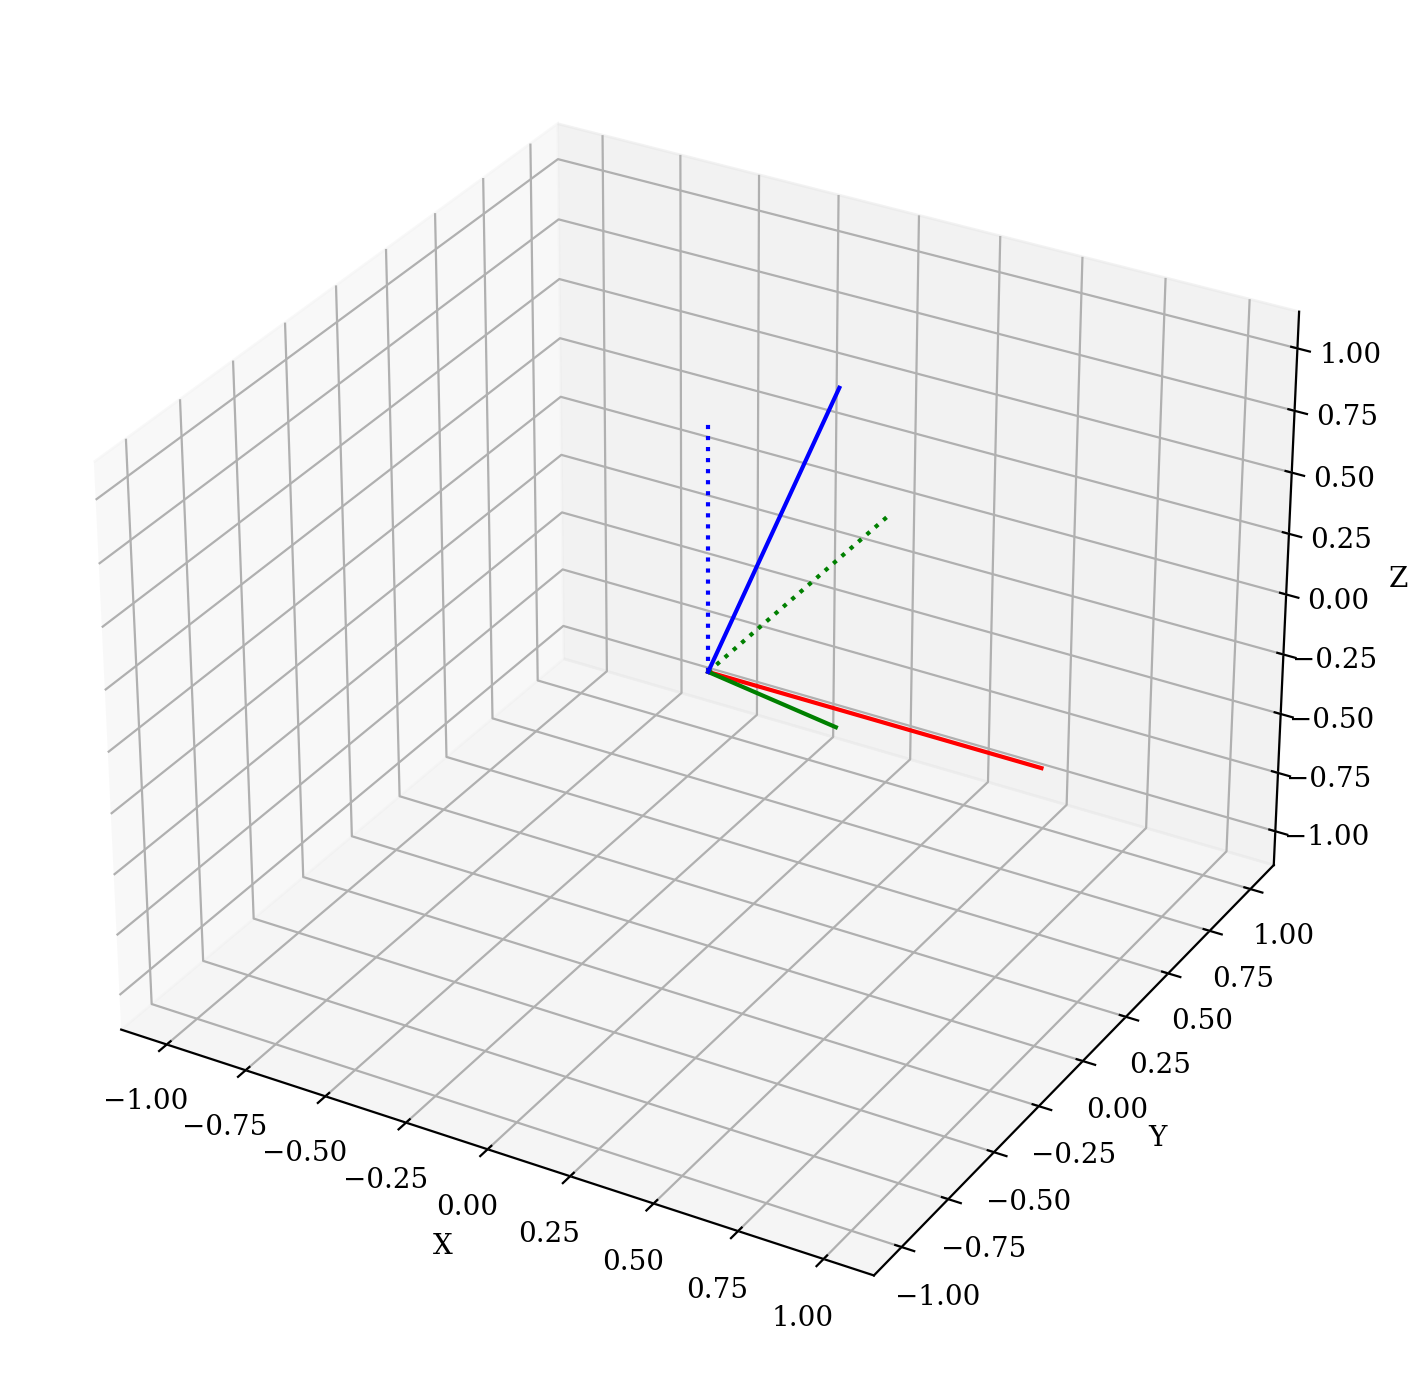

In [18]:
ax = make_3d_axes()
ax.plot(*vec_from_origin(*y_hat),
        color='green', linestyle='dotted')
ax.plot(*vec_from_origin(*z_hat),
        color='blue', linestyle='dotted')
ax.plot(*vec_from_origin(*new_x_hat.flat), color='red')
ax.plot(*vec_from_origin(*new_y_hat.flat), color='green')
ax.plot(*vec_from_origin(*new_z_hat.flat), color='blue')
plt.tight_layout()

And that's basically that!

# The devil is in the details

Just kidding, there's a few more things to worry about. For example, it's clear to see that a rotation about $\hat{z}$ corresponds to a rotation in RA for the conventions we chose:

In [19]:
new_vec = (ra_dec_to_uvec(0, 0) @ z_rot(90)).flat
uvec_to_ra_dec(*new_vec)

(270.0, 0.0)

But, while this is indeed 90º away from (0º, 0º), it's the wrong direction. So we need to rotate by *negative* RA.

In [20]:
new_vec = (ra_dec_to_uvec(0, 0) @ z_rot(-90)).flat
uvec_to_ra_dec(*new_vec)

(90.0, 0.0)

The other issue is a fundamental and vexing property of rotations: they do not commute. We need to rotate up or down in Dec as well as around in RA, so we must apply the Dec rotation *first* so that it's an easy-to-compute rotation about $\hat{y}$.

In [21]:
new_vec = (ra_dec_to_uvec(0, 0) @ y_rot(45) @ z_rot(-60)).flat
uvec_to_ra_dec(*new_vec)

(59.99999999999999, 44.99999999999999)

Compare to what happens when you rotate about $\hat{z}$ first:

In [22]:
new_vec = (ra_dec_to_uvec(0, 0) @ z_rot(-60) @ y_rot(45)).flat
uvec_to_ra_dec(*new_vec)

(67.79234570140352, 20.704811054635442)

Clearly not what we want!

We also need to support a position angle parameter, $\text{PA}$, which rotates the footprint based on the angle between the "up and down" direction on the detector and the great circle through the poles and the zenith. This is a rotation around $\hat{x}$, but the conventions in astronomy are that greater position angle should move the point in the direction of smaller right ascension (degrees East of North).

In [23]:
pos_ang = 45
new_vec = (ra_dec_to_uvec(10, 0) @ x_rot(-pos_ang)).flat
uvec_to_ra_dec(*new_vec)

(7.107076110446533, 7.053022130283182)

As you can see, this must be a rotation by _negative_ position angle in degrees East of North.

# Putting it all together

To move your polygon defined in angular coordinates centered on $(0^\circ, 0^\circ)$ to a new location $(\alpha, \delta)$, the algorithm is as follows.

For every (RA, Dec) point in the polygon:

  1. Convert polygon vertex $(\text{RA}, \text{Dec})$ coordinates into a unit vector $\vec{v}$
  2. Calculate $\vec{v'} = \vec{v} \ R_x(\text{PA})\ R_y(\text{Dec}) \ R_z(-\text{RA})$
  3. Convert $\vec{v'}$ back into RA and Dec

Let's apply this to our $10^\circ \times 10^\circ$ footprint and put it right at the pole:

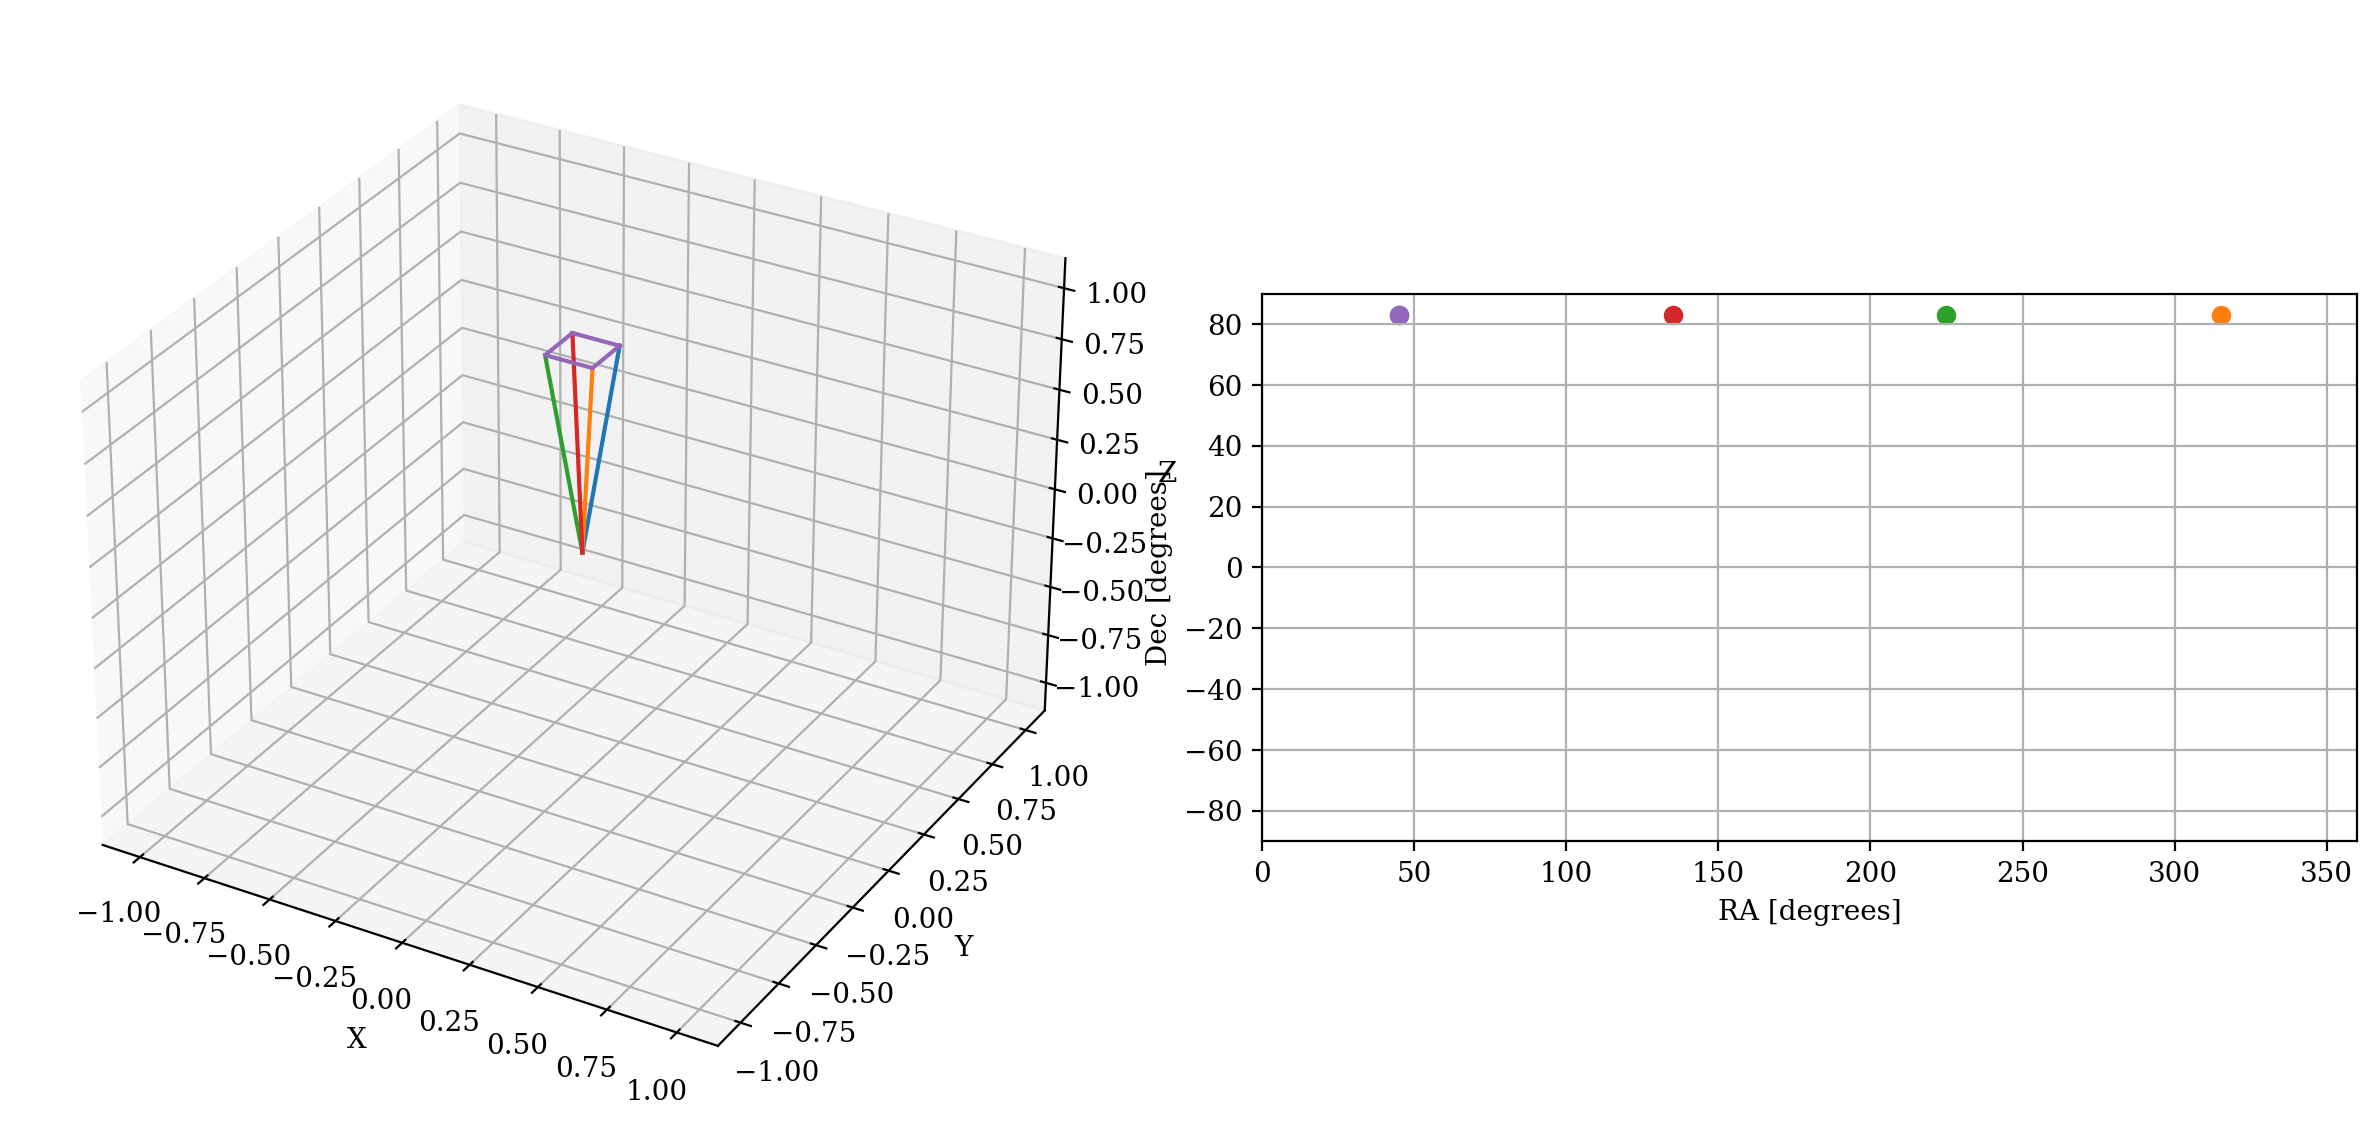

In [24]:
# Define the footprint

footprint_zero_center = [
    [-5, 5],
    [5, 5],
    [5, -5],
    [-5, -5],
]

# Define the new target location

new_ra, new_dec, pos_ang = 180, 90, 0

#### Step 1, convert the coordinates into vectors
footprint_zero_center_uvec = ra_dec_to_uvec(
    footprint_zero_center_ra,
    footprint_zero_center_dec
)
(
    footprint_zero_center_x,
    footprint_zero_center_y,
    footprint_zero_center_z
) = footprint_zero_center_uvec

def paired_plot():
    fig = plt.figure(figsize=(12, 6))
    ax = make_3d_axes(1, 2, 1)
    sky_ax = fig.add_subplot(1, 2, 2)
    sky_ax.set_xlim(0, 360)
    sky_ax.set_ylim(-90, 90)
    sky_ax.set_ylabel('Dec [degrees]')
    sky_ax.set_xlabel('RA [degrees]')
    sky_ax.set_aspect('equal')
    return ax, sky_ax
    
ax, sky_ax = paired_plot()
    
xs, ys, zs = [], [], []
for idx in range(footprint_zero_center_x.shape[0]):
    vec = np.array([
        footprint_zero_center_x[idx],
        footprint_zero_center_y[idx],
        footprint_zero_center_z[idx]
    ])
    #### Step 2, calculate v' by multiplying with the rotation matrices
    vec_prime = (
        vec 
        @ x_rot(-pos_ang) 
        @ y_rot(new_dec) 
        @ z_rot(-new_ra)
    )
    ax.plot(*vec_from_origin(*vec_prime.flat))
    xs.append(vec_prime.flat[0])
    ys.append(vec_prime.flat[1])
    zs.append(vec_prime.flat[2])

xs.append(xs[0])
ys.append(ys[0])
zs.append(zs[0])
ax.plot(xs, ys, zs) 


#### Step 3, convert back into RA and Dec
for x, y, z in zip(xs, ys, zs):
    sky_ax.scatter(*uvec_to_ra_dec(x, y, z))
plt.tight_layout()

Looks kind of funny, but that's where the corners go when you center your square footprint at the pole. Let's step through declinations and see how the footprint looks in 2D.

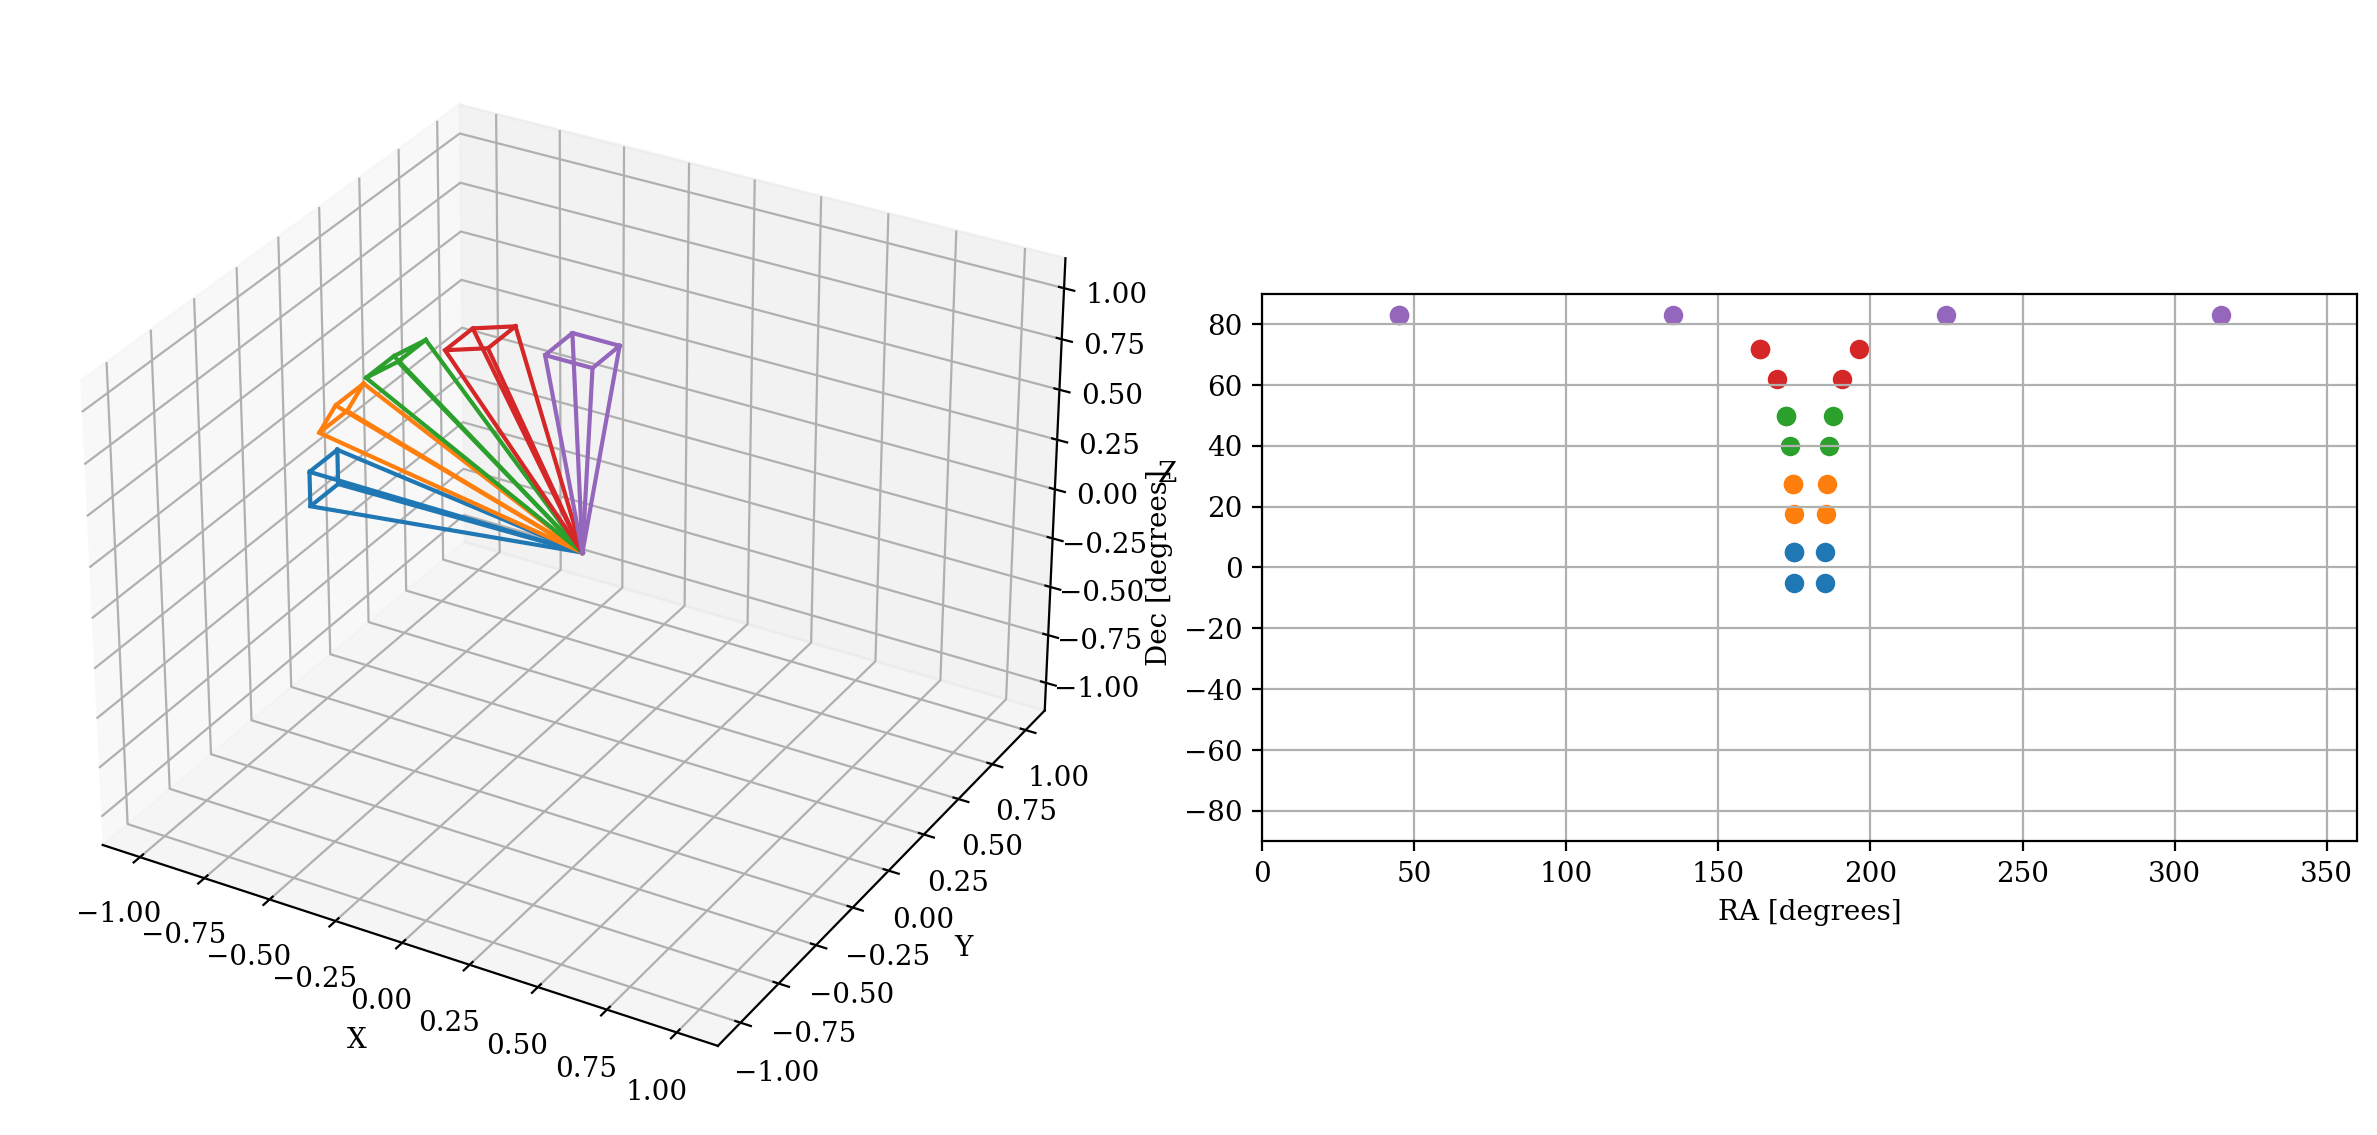

In [25]:
ax, sky_ax = paired_plot()

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

new_ra, pos_ang = 180, 0

for cidx, new_dec in enumerate([0, 22.5, 45, 67.5, 90]):
    xs, ys, zs = [], [], []
    for idx in range(footprint_zero_center_x.shape[0]):
        vec = np.array([
            footprint_zero_center_x[idx],
            footprint_zero_center_y[idx],
            footprint_zero_center_z[idx]
        ])
        vec_prime = (
            vec 
            @ x_rot(-pos_ang) 
            @ y_rot(new_dec) 
            @ z_rot(-new_ra)
        )
        ax.plot(*vec_from_origin(*vec_prime.flat), c=colors[cidx])
        xs.append(vec_prime.flat[0])
        ys.append(vec_prime.flat[1])
        zs.append(vec_prime.flat[2])

    xs.append(xs[0])
    ys.append(ys[0])
    zs.append(zs[0])
    ax.plot(xs, ys, zs, c=colors[cidx]) 
    for x, y, z in zip(xs, ys, zs):
        sky_ax.scatter(*uvec_to_ra_dec(x, y, z), color=colors[cidx])

plt.tight_layout()

Finally, check out the behavior of the position angle. Here's our footprint, rotated by 45º, as we move up to the pole.

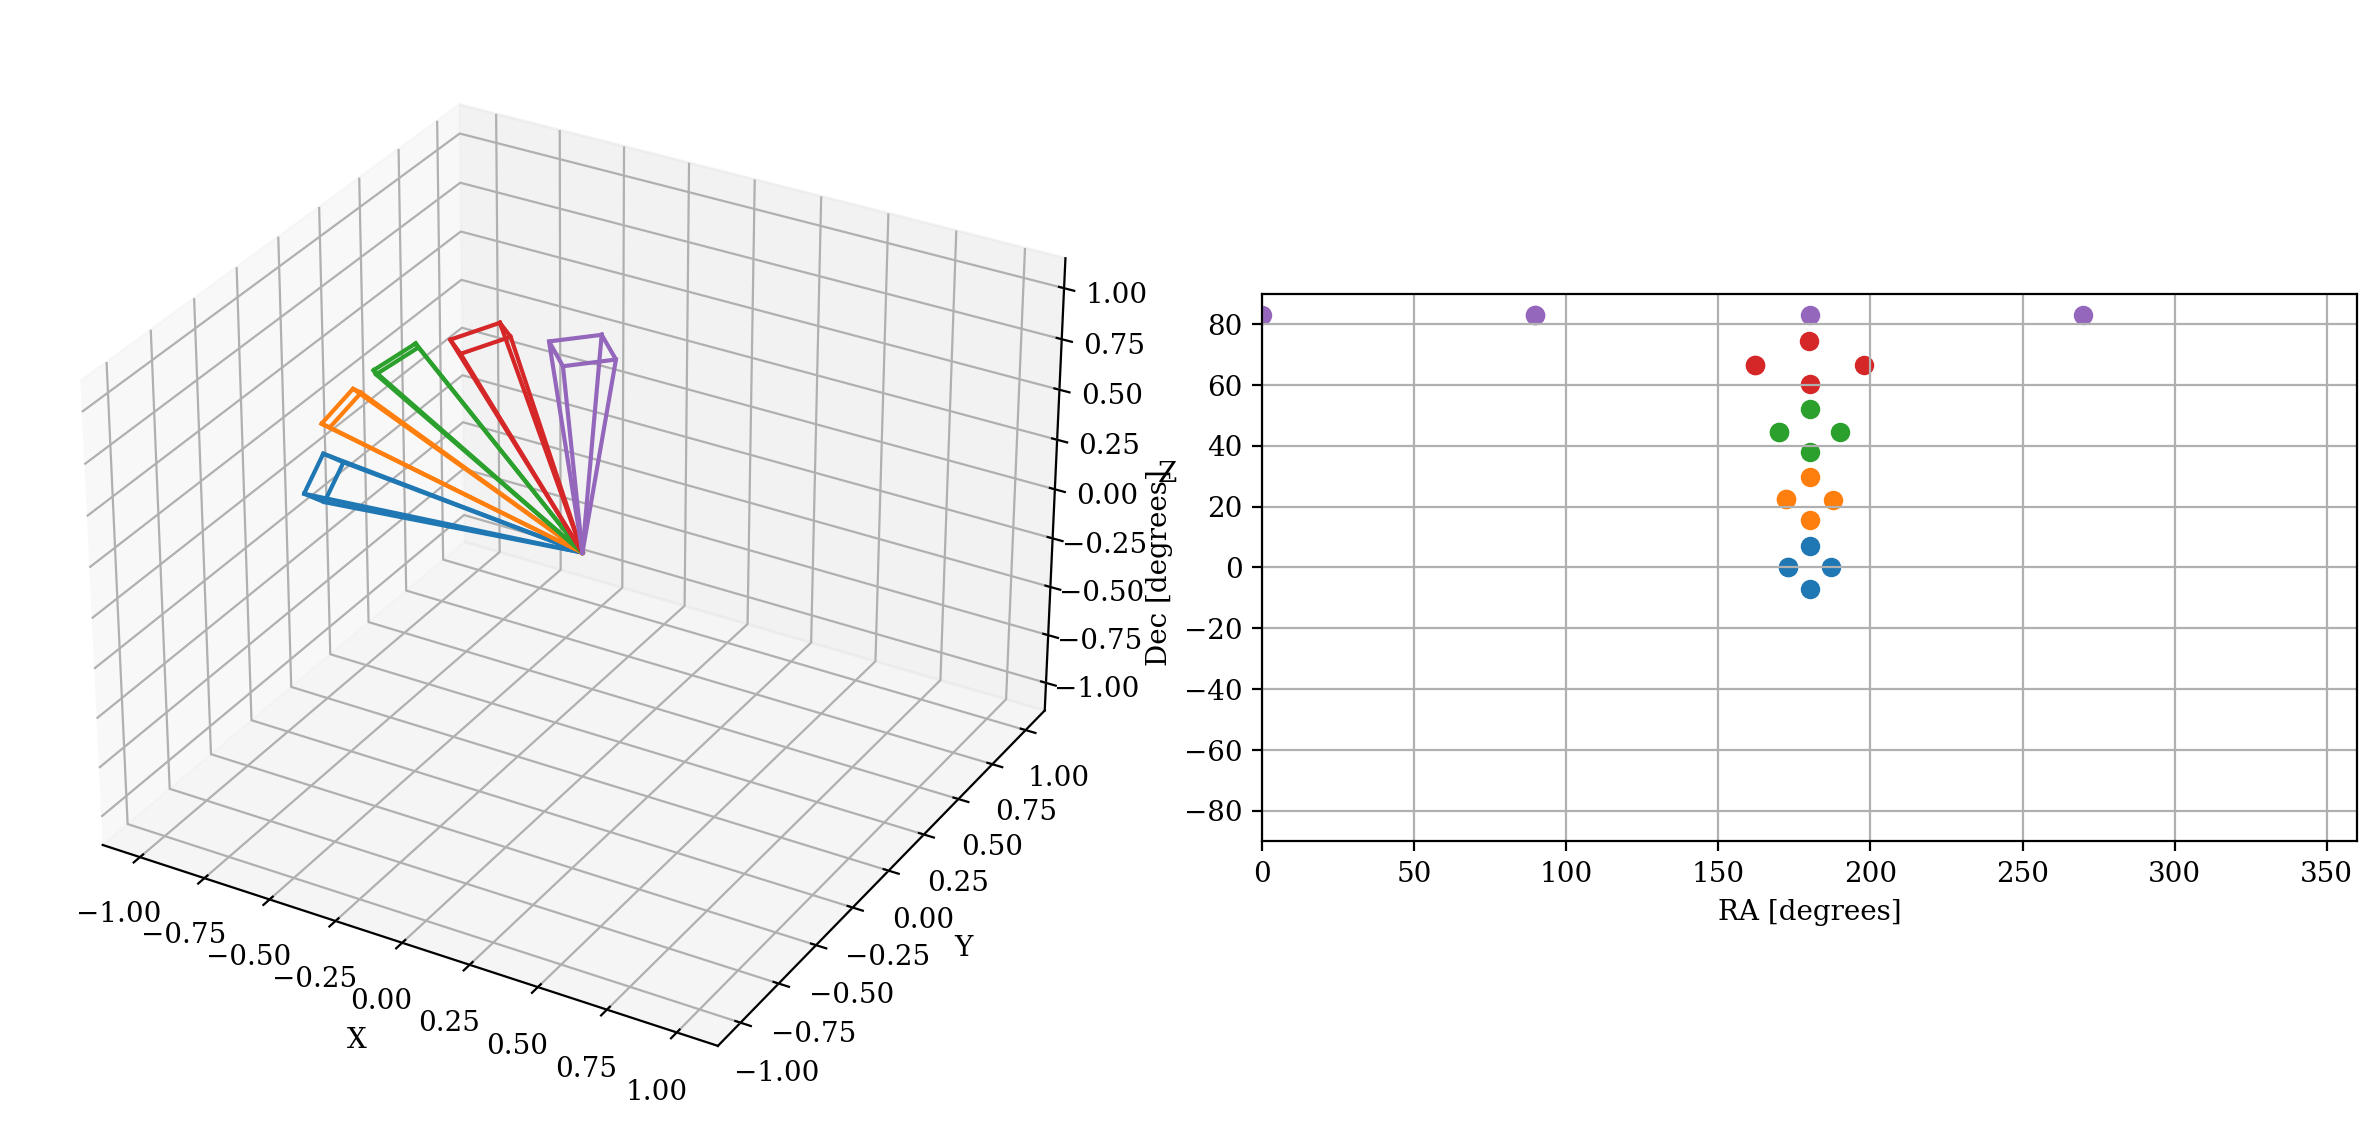

In [26]:
ax, sky_ax = paired_plot()
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
new_ra, pos_ang = 180, 45

for cidx, new_dec in enumerate([0, 22.5, 45, 67.5, 90]):
    xs, ys, zs = [], [], []
    for idx in range(footprint_zero_center_x.shape[0]):
        vec = np.array([footprint_zero_center_x[idx], footprint_zero_center_y[idx], footprint_zero_center_z[idx]])
        vec_prime = (
            vec 
            @ x_rot(-pos_ang) 
            @ y_rot(new_dec) 
            @ z_rot(-new_ra)
        )
        ax.plot(*vec_from_origin(*vec_prime.flat), c=colors[cidx])
        xs.append(vec_prime.flat[0])
        ys.append(vec_prime.flat[1])
        zs.append(vec_prime.flat[2])

    xs.append(xs[0])
    ys.append(ys[0])
    zs.append(zs[0])
    ax.plot(xs, ys, zs, c=colors[cidx]) 
    for x, y, z in zip(xs, ys, zs):
        sky_ax.scatter(*uvec_to_ra_dec(x, y, z), color=colors[cidx])
plt.tight_layout()

Hope you found this useful!

If you used this in your work, you may cite this notebook with its Zenodo DOI: [10.5281/zenodo.3529868](https://dx.doi.org/10.5281/zenodo.3529868). The code samples above are released under the terms of the [MIT license](https://choosealicense.com/licenses/mit/).